<img src="./logo_UNSAM.jpg" align="right" width="250" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº8
#### Nicolás Sewrjugin y Sofía Gervasi


# Introducción

El ciclo cardíaco típico presenta una duración promedio de aproximadamente 600 ms, durante el cual se manifiestan tres componentes morfológicos fundamentales: la onda P, que representa la despolarización auricular; el complejo QRS, correspondiente a la despolarización ventricular; y la onda T, asociada a la repolarización ventricular. Durante una prueba de esfuerzo, la señal electrocardiográfica se ve particularmente afectada por múltiples fuentes de interferencia que comprometen su calidad. Entre las principales contaminaciones se identifican el ruido de alta frecuencia, originado tanto por el movimiento de los electrodos sobre la superficie cutánea como por la actividad muscular durante el ejercicio, y el desplazamiento de la línea de base en baja frecuencia, inducida principalmente por los movimientos respiratorios.

El objetivo del presente trabajo es diseñar e implementar un conjunto de filtros digitales que permitan eliminar eficazmente estas interferencias preservando al mismo tiempo la morfología característica de la señal. Para ello, se establecerá una plantilla de diseño basada en el ancho de banda típico del ECG, se compararán distintas metodologías de diseño de filtros FIR e IIR y se evaluará el rendimiento de cada filtro tanto en su capacidad de atenuación de interferencias como en su inocuidad sobre la señal de interés.


# Análisis y desarrollo

Para la selección de los métodos de diseño de los filtros digitales para el procesamiento del ECG se consideró tanto las características particulares de la señal como las ventajas específicas de cada aproximación. 

Para los filtros IIR, se seleccionó el filtro Butterworth, ya que presenta una respuesta maximalmente plana en la banda de paso, sin ripple, lo que minimiza distorsiones en la amplitud de las componentes espectrales de la senal dentro del ancho de banda de interés. Como segunda alternativa de comparación, se eligió el filtro Cauer ya que ofrece la transición más abrupta entre banda de paso y banda de atenuación, para un filtro de derteminado orden, lo que lo hace la opción más eficiente en términos de mínimo orden.

En cuanto a los filtros FIR, el método de ventanas permite un controlar mediante la selección del tipo de ventana el compromiso deseado entre ancho de transición y atenuación en la banda rechazada, es una referencia de base ideal para comparar con técnicas más sofisticadas. Por su parte, el método de Parks-McClellan proporciona una solución equiripple, que permite especificar el ripple tolerado tanto en banda de paso como en banda de atenuación, lo que nos permite definir plantillas con especificaciones más rigurosas. 

### Plantilla de diseño

In [4]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.patches as patches

#Filtro digital  usando valores del ECG

fs = 1000 #Hz
wp = [0.8, 35] #frecuencia de corte (Hz)
ws = [0.1, 40] #frecuencia de stop (Hz) arriba de los 35 debe ser la segunda
#queremos q saque toda la frecuencia menor a 1 Hz (0.8)

alpha_p = 1 #atenuación de corte (db), alpha maxima en bp
alpha_s = 40 #atenuación de stop (db), alpha minima en bs

### Respuestas de filtros IIR 

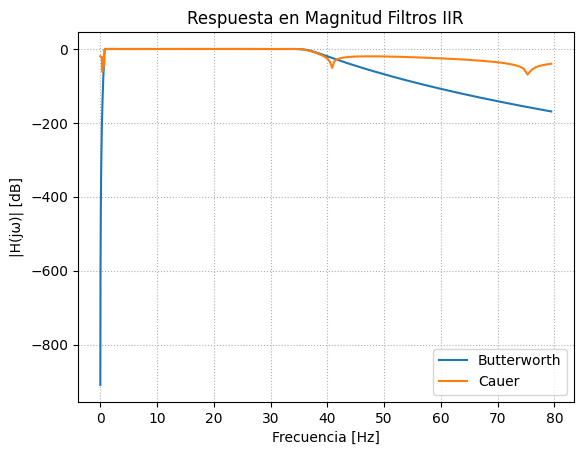

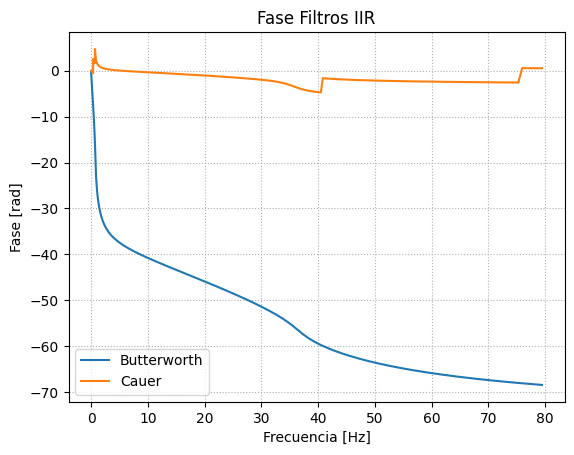

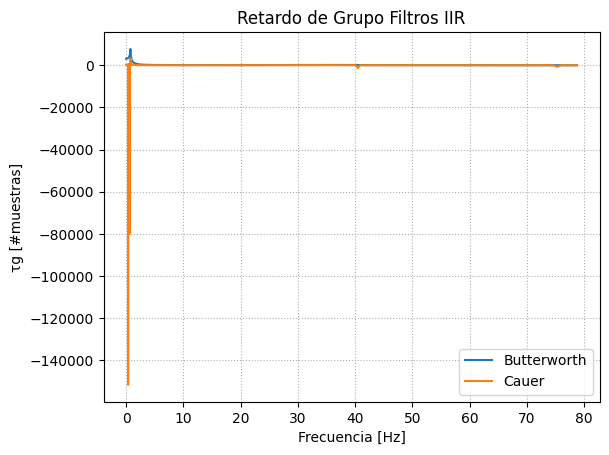

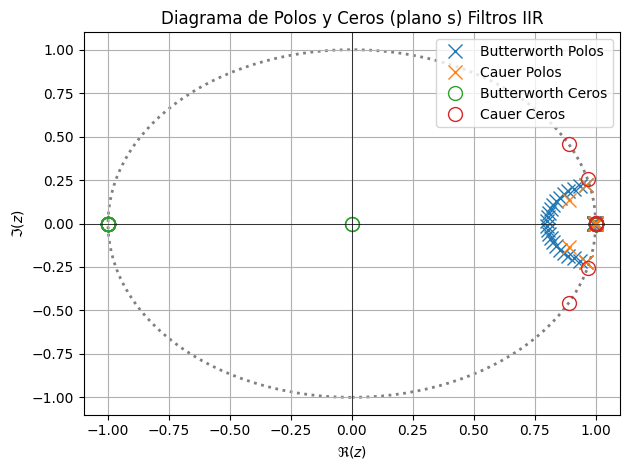

In [6]:
from scipy import signal
#Divido por 2 a los alfas pq con el filtfilt se va al doble de ripple sino (y doble de atenuación que es bueno eso) y asi podemos neutralizar la fase tranquilamente
mi_sos_butt = signal.iirdesign(wp=wp, ws= ws, gpass=alpha_p/2, gstop=alpha_s/2, analog=False, ftype="butter", output='sos', fs = fs)
mi_sos_cauer = signal.iirdesign(wp=wp, ws= ws, gpass=alpha_p/2, gstop=alpha_s/2, analog=False, ftype="cauer", output='sos', fs = fs)

w, h = signal.freqz_sos(mi_sos_butt, worN=np.logspace(-2,1.9,1000), fs = fs)
w2, h2 = signal.freqz_sos(mi_sos_cauer, worN=np.logspace(-2,1.9,1000), fs = fs)

phase = np.unwrap(np.angle(h)) #con unwrap evita la discontinuidad de fase (discontinuidad evitable)
phase2 = np.unwrap(np.angle(h2))

w_rad = w / (fs/2) *np.pi
w_rad2 = w2 / (fs/2) *np.pi

gd = -np.diff(phase)/np.diff(w_rad) #retardo de grupo
gd2 = -np.diff(phase2)/np.diff(w_rad2) 

z, p, k = signal.sos2zpk(mi_sos_butt)
z2, p2, k2 = signal.sos2zpk(mi_sos_cauer)

# Magnitud
plt.figure(1)
plt.plot(w, 20*np.log10(abs(h)), label = 'Butterworth')
plt.plot(w2, 20*np.log10(abs(h2)), label = 'Cauer')
plt.title('Respuesta en Magnitud Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Fase
plt.figure(2)
plt.plot(w, (phase), label = 'Butterworth')
plt.plot(w2, (phase2), label = 'Cauer')
plt.title('Fase Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Retardo de grupo
plt.figure(3)
plt.plot(w[:-1], gd, label = 'Butterworth')
plt.plot(w2[:-1], gd2, label = 'Cauer')
plt.title('Retardo de Grupo Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('τg [#muestras]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Diagrama de polos y ceros
plt.figure(4)
plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Butterworth Polos' )
plt.plot(np.real(p2), np.imag(p2), 'x', markersize=10, label='Cauer Polos' )
axes_hdl = plt.gca()

if len(z) > 0:
    plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Butterworth Ceros')
    plt.plot(np.real(z2), np.imag(z2), 'o', markersize=10, fillstyle='none', label='Cauer Ceros')
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
unit_circle = patches.Circle((0, 0), radius=1, fill=False,
                             color='gray', ls='dotted', lw=2)
axes_hdl.add_patch(unit_circle)

plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.title('Diagrama de Polos y Ceros (plano s) Filtros IIR')
plt.xlabel(r'$\Re(z)$')
plt.ylabel(r'$\Im(z)$')
plt.legend()
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




### Filtros IIR aplicados al ECG

C:\Users\joaqu\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\joaqu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


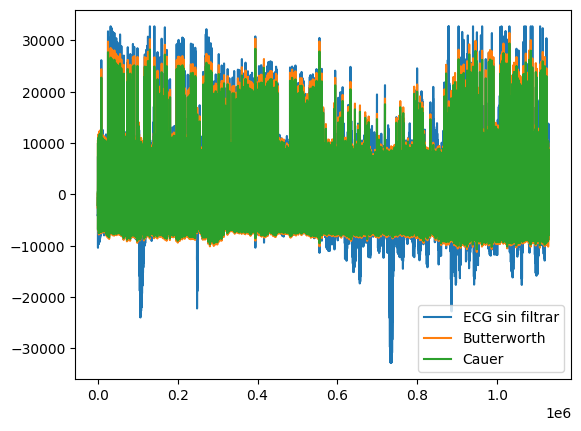

In [7]:
#ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
cant_muestras = N


ecg_filt_butt = signal.sosfiltfilt(mi_sos_butt, ecg_one_lead)
ecg_filt_cauer = signal.sosfiltfilt(mi_sos_cauer, ecg_one_lead)

plt.figure(5)
plt.plot(ecg_one_lead, label = 'ECG sin filtrar')
plt.plot(ecg_filt_butt, label = 'Butterworth')
plt.plot(ecg_filt_cauer, label = 'Cauer')
plt.legend()

### Respuestas de los filtros FIR

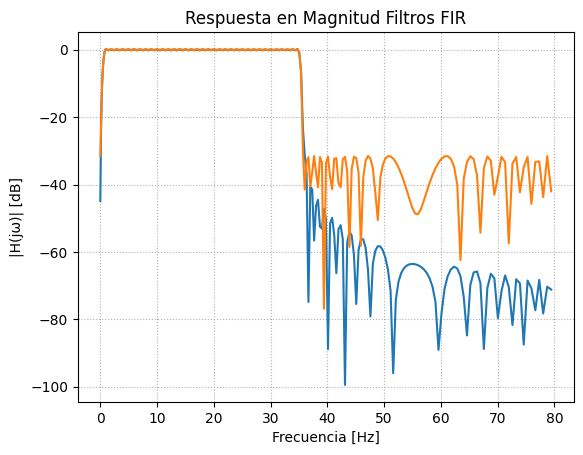

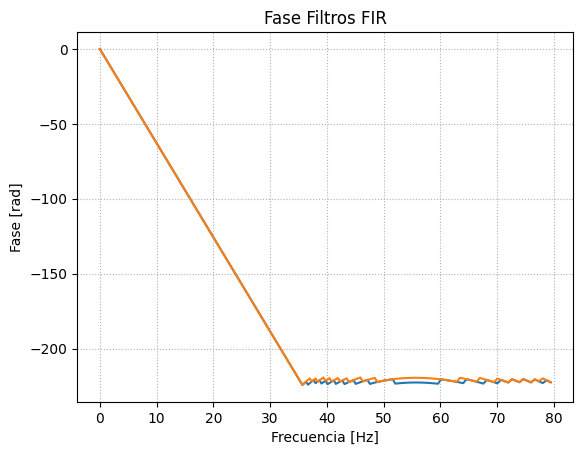

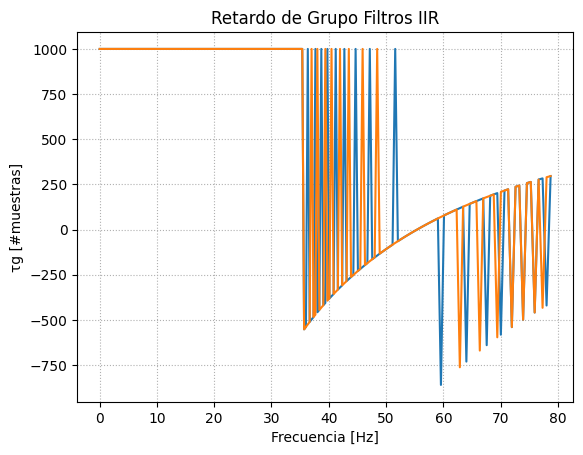

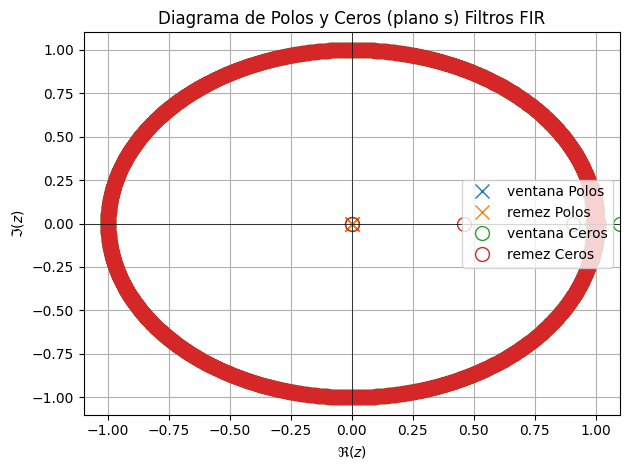

In [20]:
fs = 1000
wp = [0.8, 35] 
ws = [0.1, 35.7] #cambio de 40 a 35.7 para que la transicion sea mas ancha y tenga mas margen para ajustar el filtro

frecuencias = np.sort(np.concatenate(((0,fs/2), wp, ws))) #ordena las freqs de ws y wp en ascendente. Debe empezar en 0 y terminar en fs/2
deseado = [0,0,1,1,0,0] #la rta uno a uno con las frecuencias para que sea pasa banda
cant_coef = 2000 #filtro par. El orden es nuestro unico grado de libertad
retardo = (cant_coef -1)//2

fir_win_rect = signal.firwin2(numtaps=cant_coef, freq=frecuencias, gain=deseado, fs=fs, nfreqs=int((np.ceil(np.sqrt(cant_coef))*2)**2)-1, window='rectangular')

deseado_PM = [0,1,0] #deseado PM debe ser la mitad de las bandas
fir_win_pm = signal.remez(numtaps=cant_coef, bands=frecuencias, desired=deseado_PM, fs=fs)

w3, h3 = signal.freqz(b=fir_win_rect, worN=np.logspace(-2,1.9,1000), fs=fs) #freqz me da solo a0=1, todos los polos en el origen (misma cantidad q los ceros, igual a cant_coef) pq es FIR
w4, h4 = signal.freqz(b=fir_win_pm, worN=np.logspace(-2,1.9,1000), fs=fs)

phase3 = np.unwrap(np.angle(h3)) #con unwrap evita la discontinuidad de fase (discontinuidad evitable)
phase4 = np.unwrap(np.angle(h4))

w_rad3 = w3 / (fs/2) *np.pi
w_rad4 = w4 / (fs/2) *np.pi
gd3 = -np.diff(phase3)/np.diff(w_rad3) #retardo de grupo
gd4 = -np.diff(phase4)/np.diff(w_rad4)

z3, p3, k3 = signal.sos2zpk(signal.tf2sos(b=fir_win_rect, a=1))
z4, p4, k4 = signal.sos2zpk(signal.tf2sos(b=fir_win_pm, a=1))

plt.figure(6)
plt.plot(w3, 20*np.log10(abs(h3)), label = 'ventana')
plt.plot(w4, 20*np.log10(abs(h4)), label = 'remez')
plt.title('Respuesta en Magnitud Filtros FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')

# Fase
plt.figure(7)
plt.plot(w3, (phase3), label = 'ventana')
plt.plot(w4, (phase4), label = 'remez')
plt.title('Fase Filtros FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid(True, which='both', ls=':')

# Retardo de grupo
plt.figure(8)
plt.plot(w3[:-1], gd3, label = 'ventana')
plt.plot(w4[:-1], gd4, label = 'remez')
plt.title('Retardo de Grupo Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('τg [#muestras]')
plt.grid(True, which='both', ls=':')

# Diagrama de polos y ceros
plt.figure(9)
plt.plot(np.real(p3), np.imag(p3), 'x', markersize=10, label='ventana Polos' )
plt.plot(np.real(p4), np.imag(p4), 'x', markersize=10, label='remez Polos' )
axes_hdl = plt.gca()

if len(z) > 0:
    plt.plot(np.real(z3), np.imag(z3), 'o', markersize=10, fillstyle='none', label='ventana Ceros')
    plt.plot(np.real(z4), np.imag(z4), 'o', markersize=10, fillstyle='none', label='remez Ceros')
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
unit_circle = patches.Circle((0, 0), radius=1, fill=False,
                             color='gray', ls='dotted', lw=2)
axes_hdl.add_patch(unit_circle)

plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.title('Diagrama de Polos y Ceros (plano s) Filtros FIR')
plt.xlabel(r'$\Re(z)$')
plt.ylabel(r'$\Im(z)$')
plt.legend()
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Filtros FIR aplicados al ECG

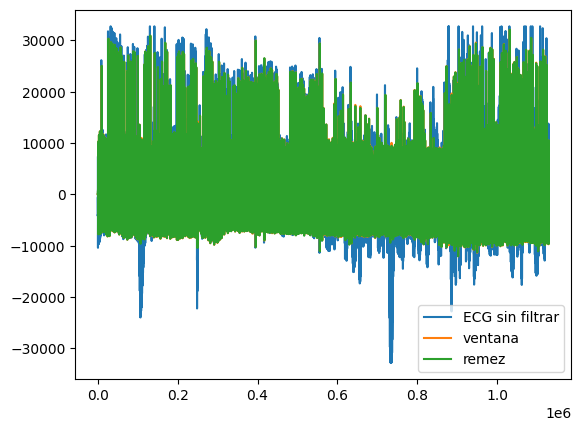

In [21]:
ecg_filt_win = signal.lfilter(b=fir_win_rect, a=1, x=ecg_one_lead)
ecg_filt_remez = signal.lfilter(b=fir_win_pm, a=1, x=ecg_one_lead)

plt.figure(10)
plt.plot(ecg_one_lead, label = 'ECG sin filtrar')
plt.plot(ecg_filt_win, label = 'ventana')
plt.plot(ecg_filt_remez, label = 'remez')
plt.legend()

### Evaluación del rendimiento de los filtros por zonas

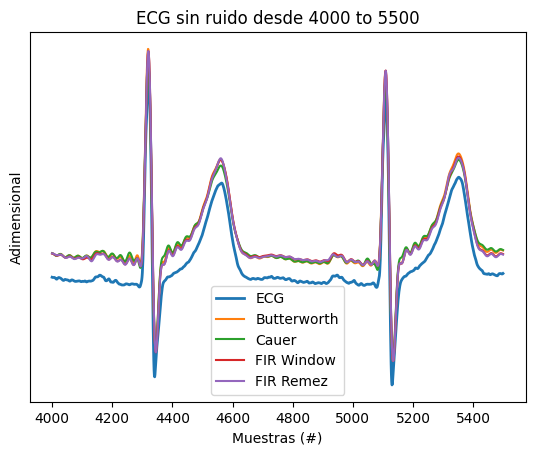

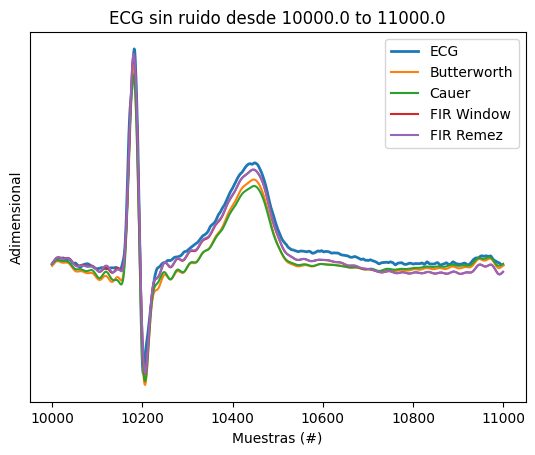

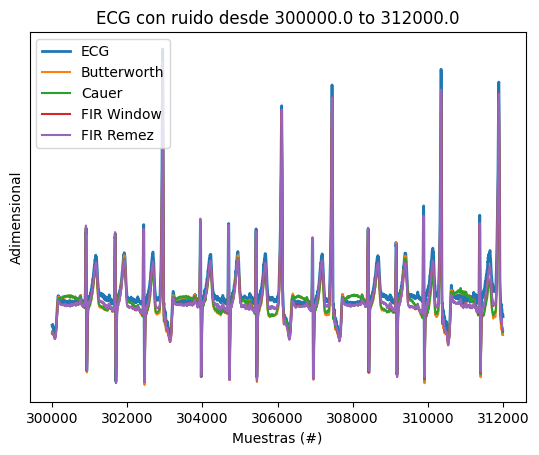

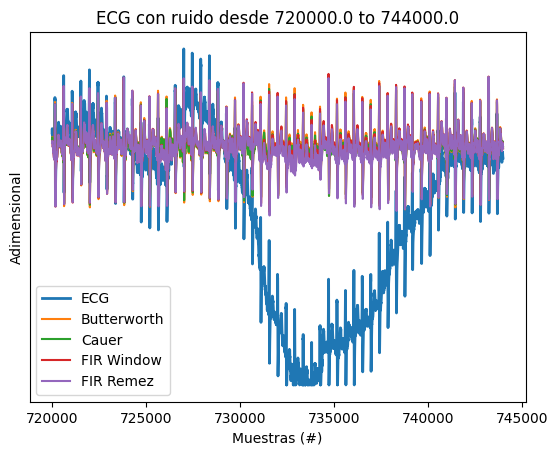

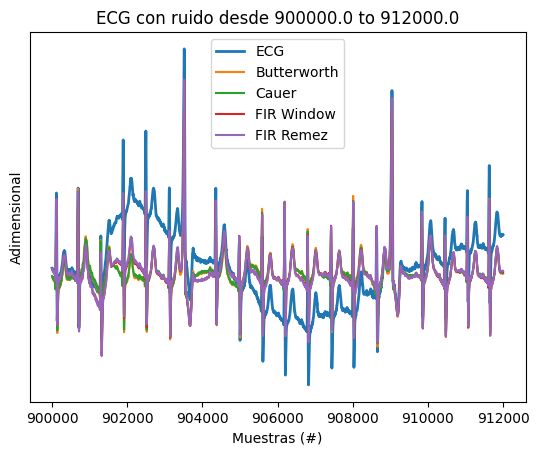

In [22]:
# Regiones de interés sin ruido 
 
regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo], label='FIR Window')
    plt.plot(zoom_region, ecg_filt_remez[zoom_region + retardo], label='FIR Remez')
   
    plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
# Regiones de interés con ruido 
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo], label='FIR Window')
    plt.plot(zoom_region, ecg_filt_remez[zoom_region + retardo], label='FIR Remez')
   
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

# Conclusiones




- definir como establecimos los valores de la plantilla.
- evaluar el rendimiento de los filtros, verificar que filtra las señales interferentes y que es inocuo en las zonas donde no hay interferentes